In [1]:
%config Completer.use_jedi = False

import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, dump, load
import time
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import NMF


#import torch
from hummingbird.ml import convert, load #https://github.com/microsoft/hummingbird
# hummingbird is usefull when you have trained model and you need to speed up prediction step
# it doesn't have nmf

from utils import load_file
from utils import DataResize
from utils import DeltaF
from utils import NMFCV
from utils import video_player
from utils import blob_labeling, image_threshold
from utils import plot_nmf_ROIs

### User inputs

In [3]:
# data address
h5_add_wt = ['I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run2_LED17ma_1h42min_small obj.h5',
          'I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run3_LED17ma_1h55min_small obj.h5',
          'I:/P6 Project/Data and Analyses/Control/210126_P5_scn2a_minus/h5/run4_LED17ma_2h11min_small obj.h5']

### Data loading

In [3]:
# load data
data = load_file(add=h5_add_wt, key_name = 'GroupHierarchy.Groups.Datasets')

C:\Users\admin\Documents\Python Scripts\P6 Project\Calcium-imaging-data-analysis\utils.py:108: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  file = h5.File(add)


selected file size: (48000, 256, 256)


### Preprocessing

In [4]:
# resizing data 
data = DataResize(data=data, dim=(128,128)).transform()
print(f'new data size: {data.shape}')

new data size: (48000, 128, 128)


#### Load resize of multiple data

In [4]:
# with 3 temporal and 0.5 spatial downsample
data = [DataResize(data = load_file(add=single_add, key_name = 'GroupHierarchy.Groups.Datasets')[::3], 
                        dim=(128,128)).transform() for single_add in h5_add_wt]

C:\Users\admin\Documents\Python Scripts\P6 Project\Calcium-imaging-data-analysis\utils.py:116: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  file = h5.File(add)


selected file size: (48000, 256, 256)
selected file size: (48000, 256, 256)
selected file size: (48000, 256, 256)


In [5]:
# combining data
data = np.vstack(data)
print(f'data size {data.shape}')

data size (48000, 128, 128)


### Feature selection

Text(0.5, 1.0, 'Max Projection')

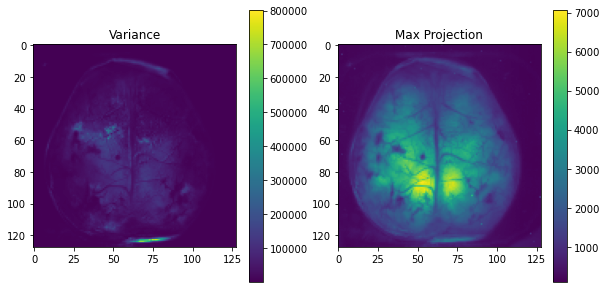

In [6]:
# feature selection

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# (1) check variance in the video
plot1 = ax1.imshow(np.var(data, axis=0))
plt.colorbar(plot1, ax = ax1)
ax1.set_title('Variance')

plot2 = ax2.imshow(np.max(data, axis=0))
plt.colorbar(plot2, ax = ax2)
ax2.set_title('Max Projection')

In [7]:
from sklearn.feature_selection import VarianceThreshold

n, p1, p2 = data.shape

# initialize class with user given threshold
var_feature = VarianceThreshold(threshold=4000)

# fit on data
var_feature.fit(data.reshape(n, p1 * p2))

# transform data
feature_selected = var_feature.transform(data.reshape(n, p1 * p2))


print(f'selected feature shape for given threshold: {feature_selected.shape}')

selected feature shape for given threshold: (48000, 10055)


reconstructed data size: (48000, 128, 128) 



HINT: PLEASE NOTICE THAT, X with columns of zeros inserted where features would have been removed by transform


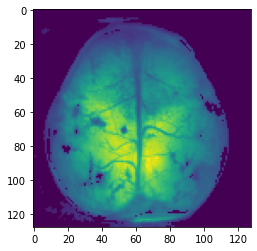

In [8]:
# reconstructing back data
data_rec = var_feature.inverse_transform(feature_selected)

# reshape back data to 3d tensor
data_rec = data_rec.reshape(n, p1, p2)

plt.imshow(np.mean(data_rec, axis=0))
print(f'reconstructed data size: {data_rec.shape} \n\n\n')
print('HINT: PLEASE NOTICE THAT, X with columns of zeros inserted where features would have been removed by transform')

In [ ]:
# if you want to get selected indices
var_feature.get_support()

In [ ]:
# saving variance model
dump(var_feature, './results/models/wt_210126_P5_scn2a_minus_run234_var_features.joblib')

In [ ]:
# loading variance model
var_feature = load('./results/models/wt_210126_P5_scn2a_minus_run234_var_features.joblib')

In [7]:
# saving selected features
np.save('./data/wt_210126_P5_scn2a_minus_run234_selected_features', feature_selected)

In [4]:
# loading data
feature_selected = np.load("./data/wt_210126_P5_scn2a_minus_run234_selected_features.npy")
print(feature_selected.shape)

### Run DeltaF

In [9]:
deltaf = DeltaF(data=feature_selected, prct=20).run_on_matrix()
deltaf = np.where(deltaf<=0, .0000001, deltaf)

100%|████████████████████████████████████| 10055/10055 [02:15<00:00, 74.16it/s]


In [10]:
# saving deltaf
np.save('./data/wt_210126_P5_scn2a_minus_run234_deltaf', deltaf)

In [2]:
# loading data
deltaf = np.load("./data/wt_210126_P5_scn2a_minus_run234_deltaf.npy")
print(deltaf.shape)

(48000, 10055)


### Video check (VAR :))

In [11]:
data_rec = var_feature.inverse_transform(deltaf)
data_rec.shape

(48000, 16384)

In [12]:
video_player(np_array_video=data_rec.reshape(-1, 128, 128)[1000:1200],, intervals_=100)

### Decomposition

#### Number of components estimation Type1

In [ ]:
nmf_cv = NMFCV(data=deltaf[::3], use_feature_selection=False, threshold=False)
cv_result = nmf_cv.estimate_componentsV1(use_parallel=True, n_jobs=3, nr_replicates=5, nr_components=(5,80,5), n_iters=200)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 106.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 588.6min


Component number with minimum test error is 20


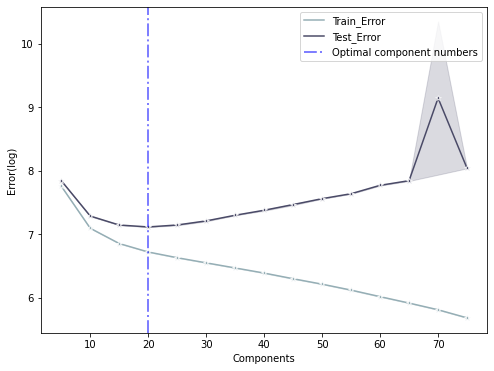

In [8]:
nmf_cv.plot_cv_results(columns = =['Components', 'Replication', 'Train_Error', 'Test_Error'], 
                       min_by = 'Test_Error', save_fig_add='./figures')

#### Number of components estimation Type2

In [ ]:
nmf_cv = NMFCV(data=deltaf, use_feature_selection=False, threshold=False)

start_time = time.clock()
cv_results = nmf_cv.estimate_componentsV2(n_jobs=10, nr_replicates=3, nr_components=[2, 80, 10])

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed: 152.8min
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed: 530.8min
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed: 987.1min


In [ ]:
# saving cv_results
np.save('./results/cv_results/wt_210126_P5_scn2a_minus_run234_cv_result.npy', cv_results)

In [ ]:
nmf_cv.plot_cv_results(columns =['Components', 'Replication', 'mse_train', 
                                   'r2_train', 'evar_train', 'mse_test', 'r2_test', 'evar_test'], 
                       min_by = 'mse_test', save_fig_add="./figures/wt_210126_P5_scn2a_minus_run234_cv_result.pdf")

#### Number of components estimate Type3

In [ ]:
nmf_cv = NMFCV(data=deltaf, use_feature_selection=False, threshold=False)

start_time = time.clock()
cv_results = nmf_cv.estimate_componentsV3(nmf_type = "Nsnmf", rank_cands=range(2, 150, 5), max_iter = 100)

print(f'execution time: {np.rint(time.clock() - start_time)} seconds')

In [ ]:
nmf_cv.plot_cv_resultsV3(save_fig_add=False)

#### Running NMF
It is good to choose nmf algorithm based on the type of algorithm used to cross-validation

In [ ]:
nmf = NMF(n_components=52, init="nndsvd", max_iter=5000, random_state=1)
traces = nmf.fit_transform(deltaf)
components = nmf.components_
print(f"shape of traces {traces.shape}, shape of components {components.shape}")

In [ ]:
# saving nmf model
dump(nmf, "./results/models/wt_210126_P5_scn2a_minus_run234_NMF.joblib")

In [ ]:
# loading nmf model
nmf = load('./results/models/wt_210126_P5_scn2a_minus_run234_NMF.joblib')

In [ ]:
# loading variance model IF not already exist
var_feature = load('./results/models/wt_210126_P5_scn2a_minus_run234_var_features.joblib')

In [ ]:
# return back components to full size
components = var_feature.inverse_transform(components)
print(f"Full size components {components.shape}")

# reshapeing back
components = components.reshape(-1, 128, 128)
print(f"Full size reshaped components {components.shape}")

#### NMF post-processing

In [ ]:
# after getting nmf result (components)

# initialize all frames dataframe
ROIs = pd.DataFrame()
binary_ROIs = []
# running on all frames
for i in range(components.shape[0]):
    ROI = blob_labeling(image=image_threshold(img = components[i], threshold=0.3))
    ROI['component_nr'] = i
    ROI['mouse_id'] = "210126_P5_scn2a_minus"
    ROIs = ROIs.append(ROI, ignore_index = True)
    binary_ROIs.append(image_threshold(img = components[i], threshold=0.3))

# make tensor of binary ROIs
binary_ROIs = np.stack(binary_ROIs)

In [ ]:
# controling thresholds
plot_nmf_ROIs(components=components, ROIs=binary_ROIs, base_w_size=6, c_min = 0, c_max = 2)

In [ ]:
# excluding artifact frames
exclude_frames = [12, 18, 24, 47]

In [ ]:
# cleaning ROIs dataframe
min_area = 20
ROIs_clean = ROIs.copy()

# excluding frames
ROIs_clean = ROIs_clean[~ROIs_clean['component_nr'].isin(exclude_frames)]

# filtering area
ROIs_clean = ROIs_clean[ROIs_clean['area'] > min_area]

ROIs_clean

In [ ]:
# saving ROIs
ROIs.to_csv("./results/ROIs/wt_210126_P5_scn2a_minus_run234_ROIsTable.csv", index = False)

In [ ]:
# loading ROIs
ROIs = pd.read_csv("./results/ROIs/wt_210126_P5_scn2a_minus_run234_ROIsTable.csv")

In [ ]:
ROIs.head(3)

In [ ]:
# saving binary components after excluding artifact frames
binary_ROIs_clean = []
binary_ROIs_clean = [binary_ROIs[i] for i in range(binary_ROIs.shape[0]) if i not in exclude_frames]
binary_ROIs_clean = np.stack(binary_ROIs_clean)
print(binary_ROIs_clean.shape)
np.save("./results/ROIs/wt_210126_P5_scn2a_minus_run234_binrayROIs.npy", binary_ROIs_clean)

In [ ]:
# load binary ROIs clean
binary_ROIs_clean = np.load("./results/ROIs/wt_210126_P5_scn2a_minus_run234_binrayROIs.npy")

### Connectivity analysis

In [ ]:
import networkx as nx
g = nx.from_numpy_matrix(np.random.rand(12,12))
labels = ['a', 'b', 'c', 'd', 'e','f', 'h', 'g', 'l', 'm', 'n','o']
label_dict = {}
for i in range(12):
    label_dict.update({i:labels[i]})
    
nx.draw(g, pos = nx.circular_layout(g), labels=label_dict, with_labels = True, node_size=500, node_color = 'red')